In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [60]:
# === Lasso and Ridge to Each Coin ===

data_folder = "USD_60_indicators"
lookahead = 1
plot_folder = "plots_lasso_ridge"
results_csv = "lasso_ridge_results.csv"

os.makedirs(plot_folder, exist_ok=True)
results = []

coin_files = [f for f in os.listdir(data_folder) if f.endswith(".parquet")]

for filename in coin_files:
    df = pd.read_parquet(os.path.join(data_folder, filename)).sort_values("timestamp")
    features = [col for col in df.columns if col not in ['timestamp', 'symbol', 'return', 'log_return']]
    df = df.dropna(subset=features + ['log_return'])
    df['target'] = df['log_return'].shift(-lookahead)
    df = df.dropna()

    X = df[features].copy()
    y = df['target'].copy()
    timestamps = df['timestamp'].copy()

    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    timestamps_test = timestamps.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = LassoCV(cv=3, max_iter=400000).fit(X_train_scaled, y_train)
    ridge = RidgeCV(cv=3).fit(X_train_scaled, y_train)
    y_pred_lasso = lasso.predict(X_test_scaled)
    y_pred_ridge = ridge.predict(X_test_scaled)

    r2_lasso = r2_score(y_test, y_pred_lasso)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    results.append({
        "coin": filename.replace("_60.parquet", ""),
        "r2_lasso": r2_lasso,
        "r2_ridge": r2_ridge,
        "mse_lasso": mse_lasso,
        "mse_ridge": mse_ridge,
        "mean_actual_return": y_test.mean(),
        "std_actual_return": y_test.std()
    })

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.values, label="True", alpha=0.6)
    plt.plot(y_pred_lasso, label="Lasso", alpha=0.8)
    plt.plot(y_pred_ridge, label="Ridge", alpha=0.8)
    plt.title(f"{filename.replace('_60.parquet','')}: Test Set Prediction")
    plt.xlabel("Time Index")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{plot_folder}/{filename.replace('.parquet', '')}_prediction.png")
    plt.close()

results_df = pd.DataFrame(results)
results_df.to_csv(results_csv, index=False)
print(f"\nSaved all metrics to {results_csv}")


Saved all metrics to lasso_ridge_results.csv


In [61]:
metrics_df = pd.read_csv("lasso_ridge_results.csv")

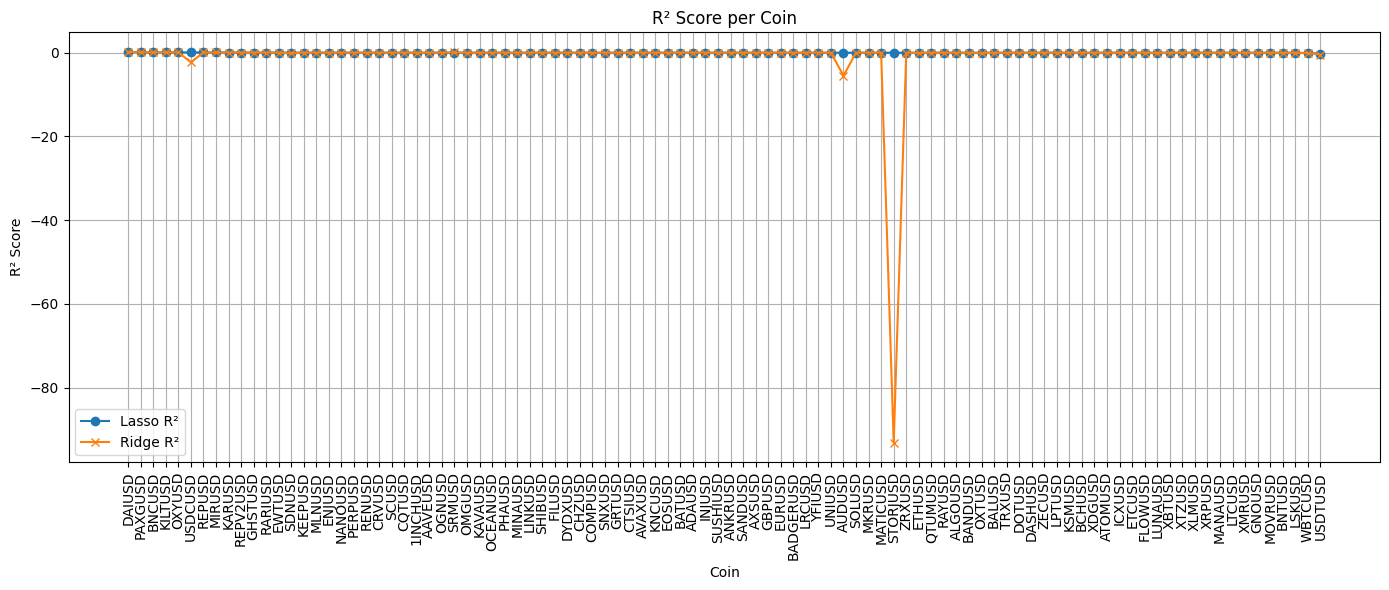

In [62]:
# === Plot Lasso and Ridge R² vs. Coins ===
metrics_df = metrics_df.sort_values("r2_lasso", ascending=False)
plt.figure(figsize=(14, 6))
plt.plot(metrics_df['coin'], metrics_df['r2_lasso'], label="Lasso R²", marker='o')
plt.plot(metrics_df['coin'], metrics_df['r2_ridge'], label="Ridge R²", marker='x')
plt.title("R² Score per Coin")
plt.xlabel("Coin")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

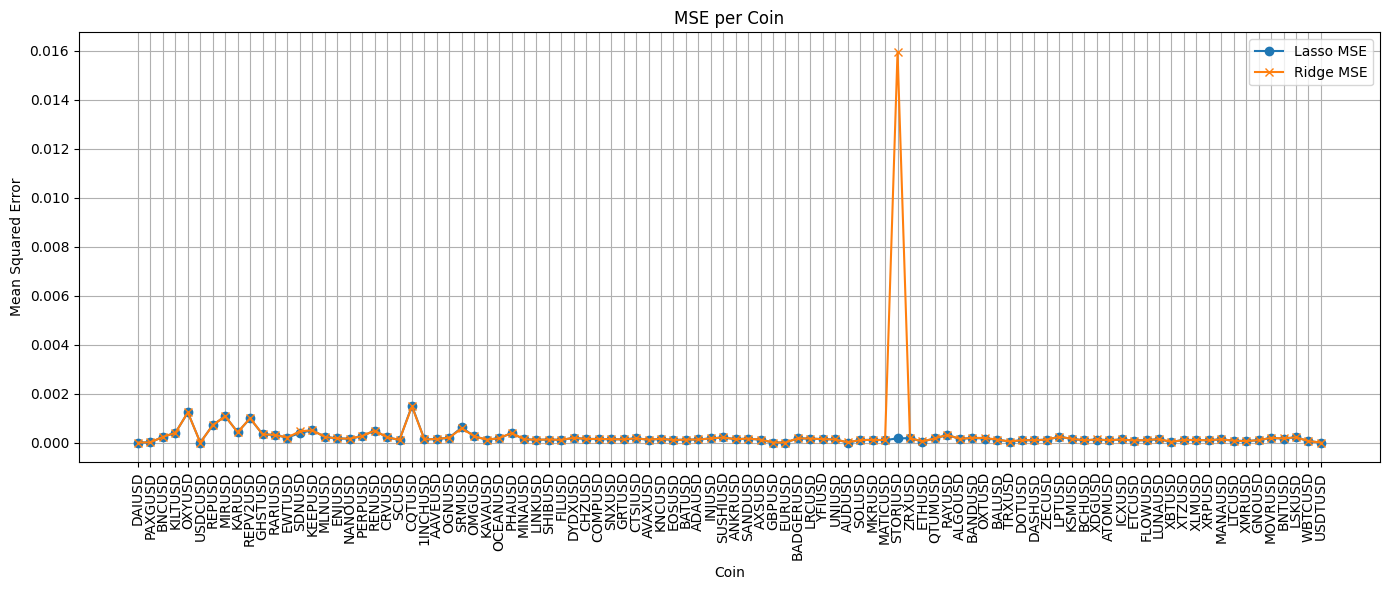

In [63]:
# === Plot MSE per Coin ===
plt.figure(figsize=(14, 6))
plt.plot(metrics_df['coin'], metrics_df['mse_lasso'], label="Lasso MSE", marker='o')
plt.plot(metrics_df['coin'], metrics_df['mse_ridge'], label="Ridge MSE", marker='x')
plt.title("MSE per Coin")
plt.xlabel("Coin")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

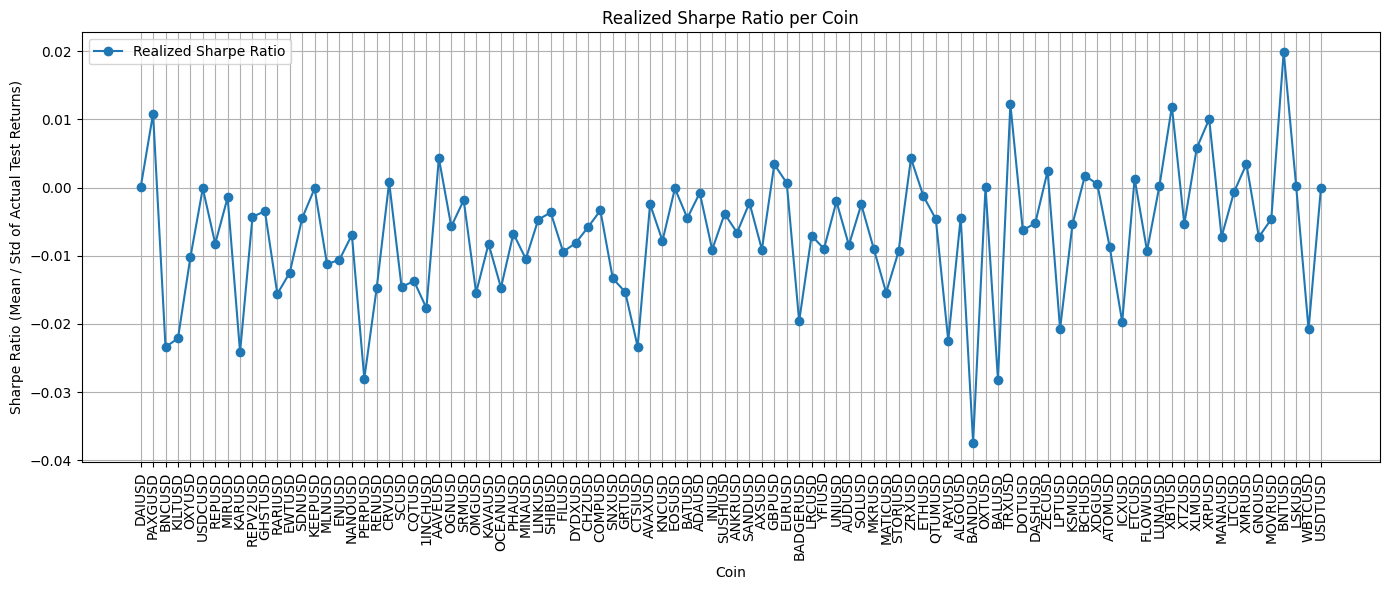

In [65]:
# === Plot Sharpe Ratio per Coin ===

# Calculate Sharpe ratio using *actual* returns
metrics_df["realized_sharpe"] = metrics_df["mean_actual_return"] / metrics_df["std_actual_return"]

plt.figure(figsize=(14, 6))
plt.plot(metrics_df['coin'], metrics_df['realized_sharpe'], label="Realized Sharpe Ratio", marker='o', linestyle='-')
plt.title("Realized Sharpe Ratio per Coin")
plt.xlabel("Coin")
plt.ylabel("Sharpe Ratio (Mean / Std of Actual Test Returns)")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# === Sharpe Threshold Evaluation ===

# Filter realistically
threshold = 2.0
filtered_df = metrics_df[metrics_df["realized_sharpe"] < threshold]

outliers = metrics_df[
    (metrics_df["r2_lasso"] < -1) | 
    (metrics_df["r2_ridge"] < -1) |
    (metrics_df["mse_lasso"] > 0.01) | 
    (metrics_df["mse_ridge"] > 0.01)
]["coin"].tolist()

filtered_df.to_csv("filtered_sharpe_coins_realistic.csv", index=False)
print("Saved filtered results to filtered_sharpe_coins_realistic.csv")
print(f"{len(filtered_df)} coins passed the Sharpe threshold.")
print(f"{len(metrics_df) - len(filtered_df)} coins failed the Sharpe threshold.")

print("\nOutliers:", outliers)

Saved filtered results to filtered_sharpe_coins_realistic.csv
96 coins passed the Sharpe threshold.
0 coins failed the Sharpe threshold.

Outliers: ['USDCUSD', 'AUDUSD', 'STORJUSD']


In [67]:
# Exclude outliers like STORJUSD
filtered_df = filtered_df[~filtered_df['coin'].isin(outliers)]
filtered_df.to_csv("filtered_sharpe_coins_realistic.csv", index=False)

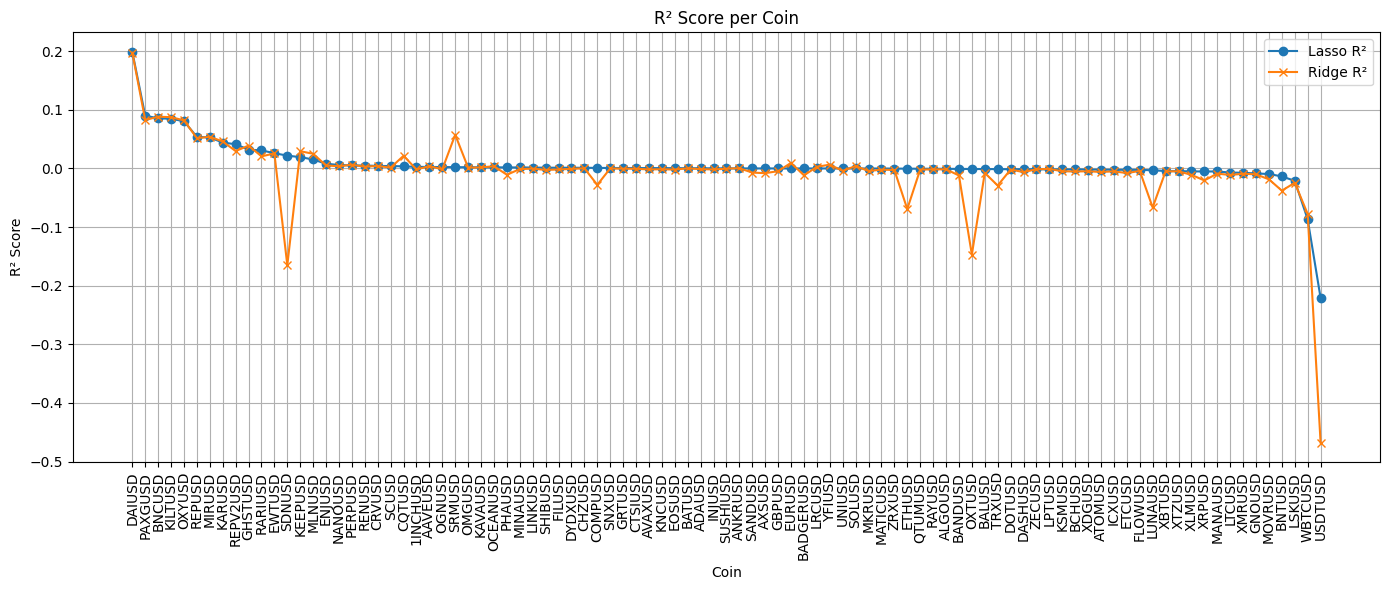

In [68]:
# === Plot Lasso and Ridge R² vs. Coins ===
filtered_df = filtered_df.sort_values("r2_lasso", ascending=False)
plt.figure(figsize=(14, 6))
plt.plot(filtered_df['coin'], filtered_df['r2_lasso'], label="Lasso R²", marker='o')
plt.plot(filtered_df['coin'], filtered_df['r2_ridge'], label="Ridge R²", marker='x')
plt.title("R² Score per Coin")
plt.xlabel("Coin")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

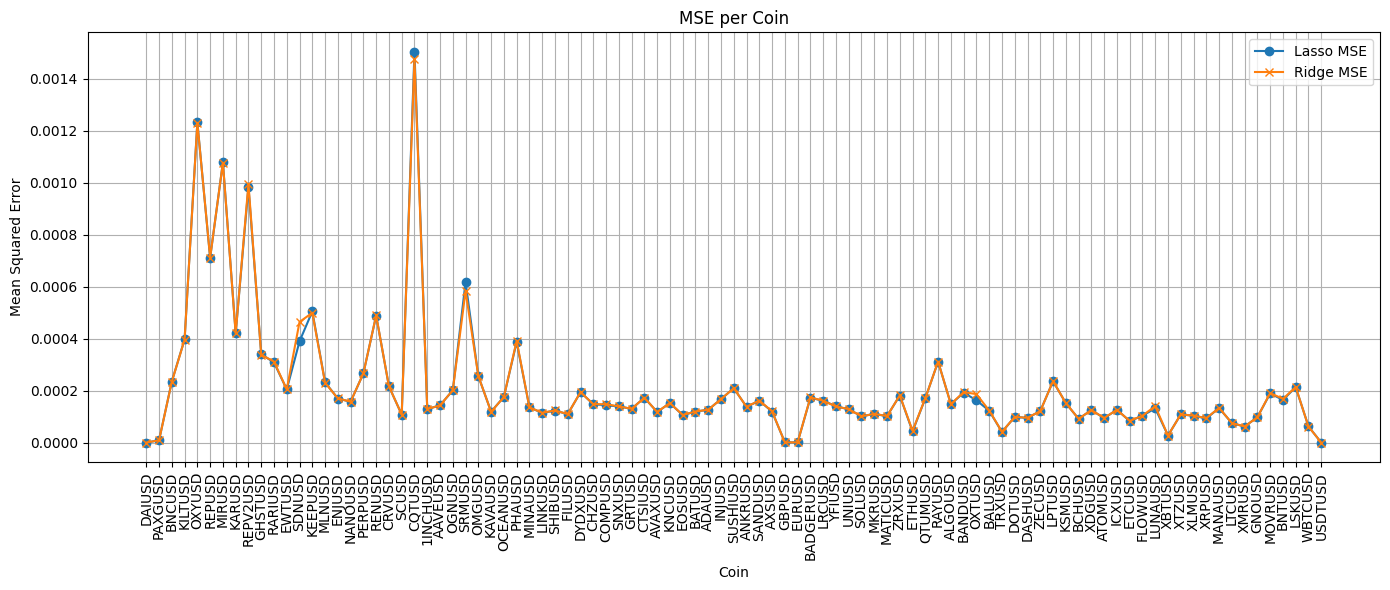

In [69]:
# === Plot MSE per Coin ===
plt.figure(figsize=(14, 6))
plt.plot(filtered_df['coin'], filtered_df['mse_lasso'], label="Lasso MSE", marker='o')
plt.plot(filtered_df['coin'], filtered_df['mse_ridge'], label="Ridge MSE", marker='x')
plt.title("MSE per Coin")
plt.xlabel("Coin")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

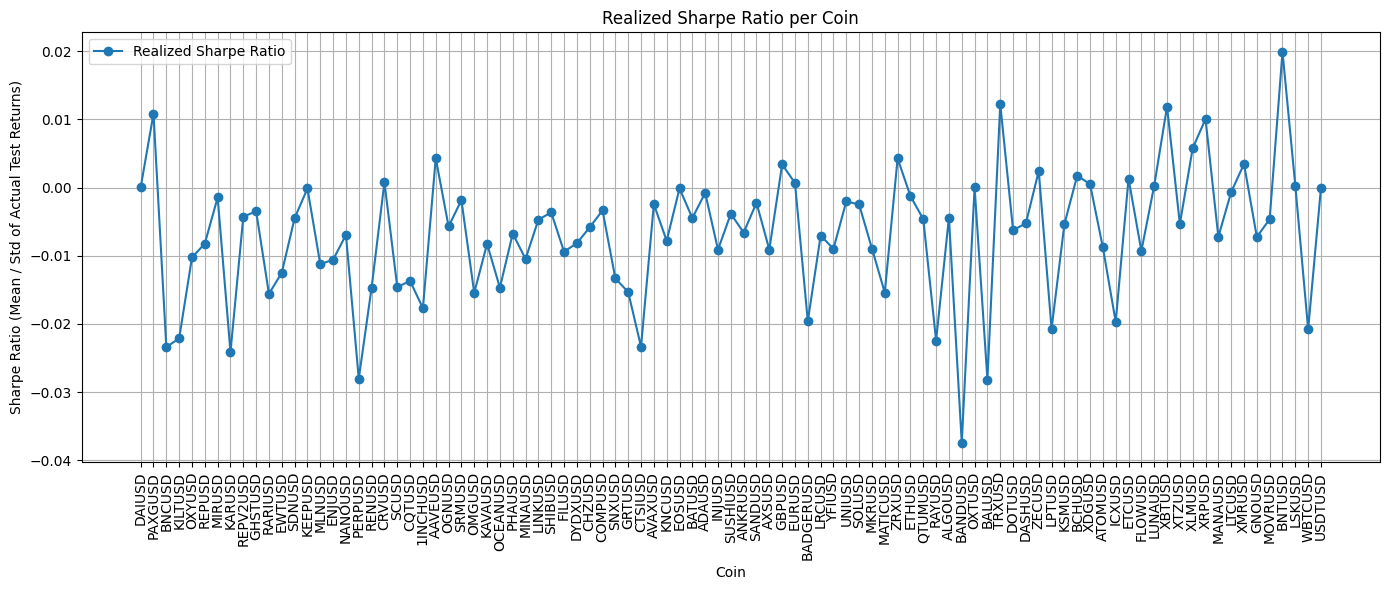

In [70]:
# === Plot Sharpe Ratio per Coin ===
plt.figure(figsize=(14, 6))
plt.plot(filtered_df['coin'], filtered_df['realized_sharpe'], label="Realized Sharpe Ratio", marker='o', linestyle='-')
plt.title("Realized Sharpe Ratio per Coin")
plt.xlabel("Coin")
plt.ylabel("Sharpe Ratio (Mean / Std of Actual Test Returns)")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
print(filtered_df[filtered_df["coin"].isin(outliers)])

Empty DataFrame
Columns: [coin, r2_lasso, r2_ridge, mse_lasso, mse_ridge, mean_actual_return, std_actual_return, realized_sharpe]
Index: []



Sharpe ratio across filtered coins (annualized hourly): 28.6509


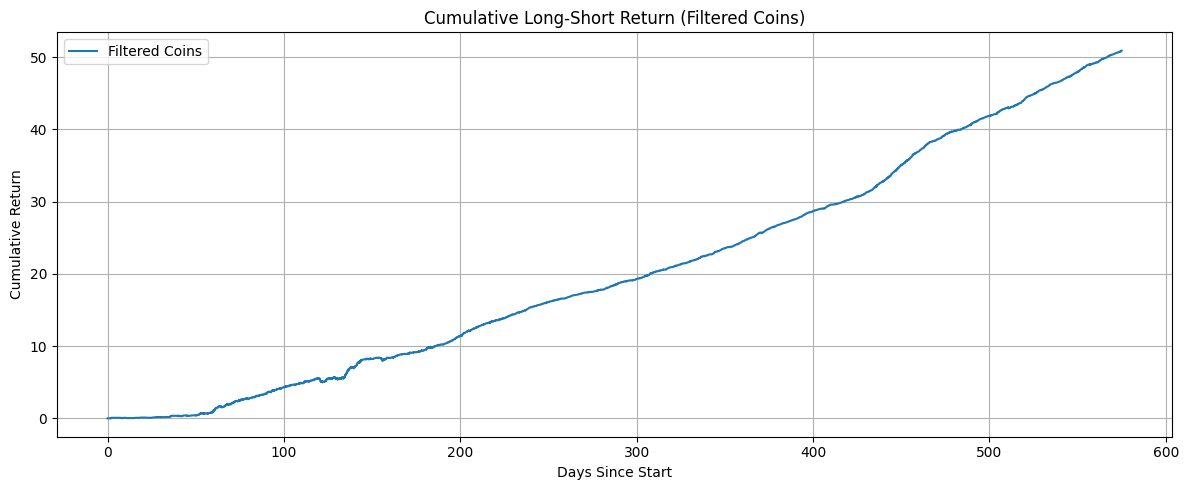

In [72]:
# === All coins together ===

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# === Settings ===
data_folder = "USD_60_indicators"
lookahead = 1
filtered_coins = set(filtered_df['coin'])

all_preds = []

for coin in filtered_coins:
    file = f"{coin}_60.parquet"
    df = pd.read_parquet(os.path.join(data_folder, file)).sort_values("timestamp")
    features = [col for col in df.columns if col not in ['timestamp', 'symbol', 'return', 'log_return']]
    df = df.dropna(subset=features + ['log_return'])
    df['target'] = df['log_return'].shift(-lookahead)
    df = df.dropna()

    X = df[features]
    y = df['target']
    timestamps = df['timestamp']

    split_idx = int(0.8 * len(X))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test = X_scaled[split_idx:]
    y_test = y.iloc[split_idx:]
    timestamps_test = timestamps.iloc[split_idx:]

    model = LassoCV(cv=3, max_iter=400000).fit(X_scaled[:split_idx], y.iloc[:split_idx])
    y_pred = model.predict(X_test)

    preds_df = pd.DataFrame({
        'timestamp': timestamps_test.values,
        'coin': coin,
        'actual_return': y_test.values,
        'predicted_return': y_pred
    })
    all_preds.append(preds_df)

df_all = pd.concat(all_preds).sort_values('timestamp').dropna()

# === Long-Short Construction ===
portfolio_returns = []
top_decile = 0.1
bottom_decile = 0.1

for timestamp, group in df_all.groupby("timestamp"):
    group = group.sort_values("predicted_return", ascending=False)
    n = len(group)
    if n < 10: continue
    top_n = int(n * top_decile)
    bottom_n = int(n * bottom_decile)
    long_short = group.iloc[:top_n]['actual_return'].mean() - group.iloc[-bottom_n:]['actual_return'].mean()
    portfolio_returns.append({"timestamp": timestamp, "long_short_return": long_short})

df_portfolio = pd.DataFrame(portfolio_returns).sort_values("timestamp")
df_portfolio['cumulative_return'] = df_portfolio['long_short_return'].cumsum()

# === Convert timestamp to "days since start"
start_time = df_portfolio['timestamp'].min()
df_portfolio['days_since_start'] = (df_portfolio['timestamp'] - start_time) / (60 * 60 * 24)

# === Sharpe Ratio
def compute_sharpe(df, annualization_factor=8760):
    r = df['long_short_return']
    return (r.mean() / r.std()) * np.sqrt(annualization_factor)

sharpe_ratio = compute_sharpe(df_portfolio)
print(f"\nSharpe ratio across filtered coins (annualized hourly): {sharpe_ratio:.4f}")

# === Plot
plt.figure(figsize=(12, 5))
plt.plot(df_portfolio['days_since_start'], df_portfolio['cumulative_return'], label="Filtered Coins")
plt.title("Cumulative Long-Short Return (Filtered Coins)")
plt.xlabel("Days Since Start")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
### BREAK